In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import TrueNegatives, TruePositives, FalseNegatives, FalsePositives
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터셋 생성

In [2]:
import os

X = np.empty((2000, 128, 128, 3))
Y = np.empty((2000,))

target = 'Bicycle'

folders = os.listdir('./images')
folders.remove(target)
folders.remove('Other')

files = os.listdir(f'./images/{target}')
for i in range(1000):
    x = cv2.imread(f"./images/{target}/{files[i]}")
    X[i] = cv2.resize(x, (128, 128))
    Y[i] = 1

files = os.listdir('./images/Other')
for i in range(300):
    x = cv2.imread(f"./images/Other/{files[i]}")
    X[i+1000] = cv2.resize(x, (128, 128))
    Y[i+1000] = 0

for f in range(7):
    files = os.listdir(f'./images/{folders[f]}')
    for i in range(100):
        x = cv2.imread(f"./images/{folders[f]}/{files[i]}")
        X[1300+f*100+i] = cv2.resize(x, (128, 128))
        Y[1300+f*100+i] = 0

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [4]:
print(X_train.shape)
print(X_test.shape)
print( y_train.shape)
print(y_test.shape)

(1500, 128, 128, 3)
(500, 128, 128, 3)
(1500,)
(500,)


In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 모델 생성

In [6]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy',
        f1_score, 
        TruePositives(name='TP'),
        TrueNegatives(name='TN'),
        FalsePositives(name='FP'),
        FalseNegatives(name='FN'),
    ],
)

In [8]:
modelpath=f"./history/{target.lower()}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [9]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=100, verbose='auto', callbacks=[early_stopping_callback,checkpointer])

12/12 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.5209 - f1_score: 0.3992 - TP: 181.0000 - TN: 405.0000 - FP: 171.0000 - FN: 368.0000
Epoch 2: val_loss improved from 0.69610 to 0.69160, saving model to ./models\bicycle.hdf5
12/12 [==============================] - 31s 3s/step - loss: 0.6970 - accuracy: 0.5209 - f1_score: 0.3992 - TP: 181.0000 - TN: 405.0000 - FP: 171.0000 - FN: 368.0000 - val_loss: 0.6916 - val_accuracy: 0.4747 - val_f1_score: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 178.0000 - val_FP: 0.0000e+00 - val_FN: 197.0000
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.5164 - f1_score: 0.4380 - TP: 221.0000 - TN: 360.0000 - FP: 216.0000 - FN: 328.0000
Epoch 3: val_loss improved from 0.69160 to 0.68248, saving model to ./models\bicycle.hdf5
12/12 [==============================] - 29s 2s/step - loss: 0.6890 - accuracy: 0.5164 - f1_score: 0.4380 - TP: 221.0000 - TN: 360.0000 - FP: 216.0000 - FN: 328.0000 - va

In [10]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

16/16 [==============================] - 3s 192ms/step - loss: 0.7208 - accuracy: 0.7980 - f1_score: 0.7960 - TP: 209.0000 - TN: 190.0000 - FP: 56.0000 - FN: 45.0000


[0.7207697033882141,
 0.7979999780654907,
 0.7959541082382202,
 209.0,
 190.0,
 56.0,
 45.0]

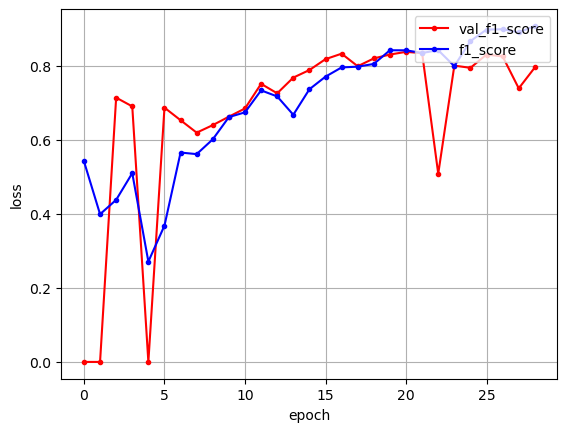

In [11]:
val_f1_score = history.history['val_f1_score']
f1_score = history.history['f1_score']

x_len = np.arange(len(f1_score))
plt.plot(x_len, val_f1_score, marker='.', c="red", label='val_f1_score')
plt.plot(x_len, f1_score, marker='.', c="blue", label='f1_score')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

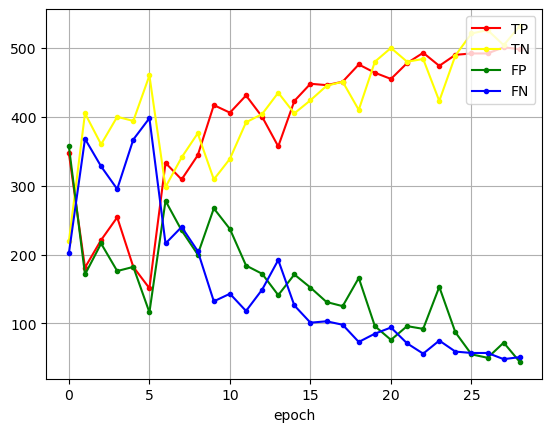

In [12]:
TP = history.history['TP']
TN = history.history['TN']
FP = history.history['FP']
FN = history.history['FN']

x_len = np.arange(len(TP))
plt.plot(x_len, TP, marker='.', c="red", label='TP')
plt.plot(x_len, TN, marker='.', c="yellow", label='TN')
plt.plot(x_len, FP, marker='.', c="green", label='FP')
plt.plot(x_len, FN, marker='.', c="blue", label='FN')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.show()

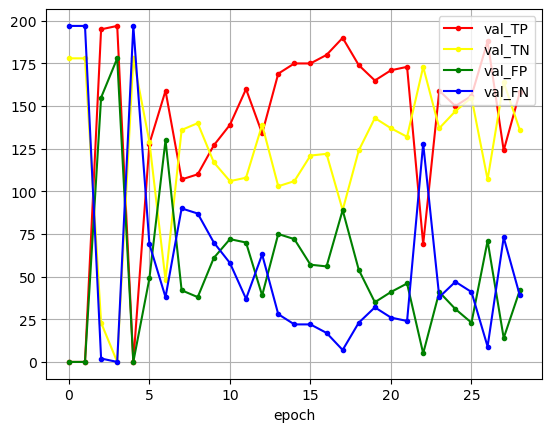

In [13]:
val_TP = history.history['val_TP']
val_TN = history.history['val_TN']
val_FP = history.history['val_FP']
val_FN = history.history['val_FN']

x_len = np.arange(len(TP))
plt.plot(x_len, val_TP, marker='.', c="red", label='val_TP')
plt.plot(x_len, val_TN, marker='.', c="yellow", label='val_TN')
plt.plot(x_len, val_FP, marker='.', c="green", label='val_FP')
plt.plot(x_len, val_FN, marker='.', c="blue", label='val_FN')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.show()

In [14]:
model.save(f"./models/{target.lower()}.hdf5")